<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objectives
- To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
- To understand the importance of a complex loss function.
- To see how we can optimize not only over network parameters, but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](https://github.com/wingated/cs474_labs/blob/master/images/style1.png?raw=true)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

# from google.colab import files

In [2]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])


In [3]:
# After the images are uploaded on to the local filesystem, you can use:
# content_filename = input('What is the name of the content file?\n').strip()
# style_filename = input('What is the name of the style file?\n').strip()

device = torch.device('mps')


content_image_orig = Image.open('lab5-images/HopePhoto3.png')
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).to(device)
content_image = content_image[:,:3,:,:]
style_image_orig = Image.open('lab5-images/ChristInField.png')
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).to(device)
style_image = style_image[:,:3,:,:]


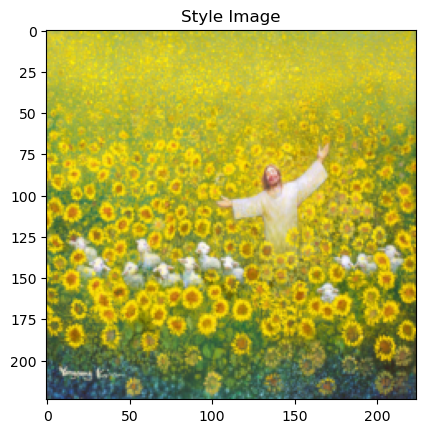

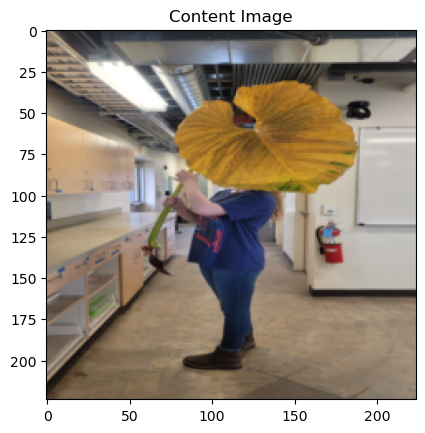

In [4]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a network instance to extract the layers needed for statistics

**TODO:**

* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image

**DONE:**



In [5]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).to(device), std=torch.tensor([0.229, 0.224, 0.225]).to(device)):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [6]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
style_layer1 = vgg_names.index('conv1_1')
style_layer2 = vgg_names.index('conv2_1')
style_layer3 = vgg_names.index('conv3_1')
style_layer4 = vgg_names.index('conv4_1')
style_layer5 = vgg_names.index('conv5_1')

content_layer = vgg_names.index('conv4_2')

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
requested = [style_layer1, style_layer2, style_layer3, style_layer4, style_layer5, content_layer]
# requested = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1', 'conv4_2']
model = VGGIntermediate(requested)
model.to(device)
# Cache the outputs of the content and style layers for their respective images
# *** the .squeeze() gets rid of the batch dimension ***
# *** the .view(number, -1) keeps the first dim as number size and combines the last two dims into 1 ***
print(style_image.size())
style_output = model(style_image)
style_output1 = style_output[style_layer1].detach()
style_output2 = style_output[style_layer2].detach()
style_output3 = style_output[style_layer3].detach()
style_output4 = style_output[style_layer4].detach()
style_output5 = style_output[style_layer5].detach()

content_output = model(content_image)
content_output = content_output[content_layer].detach()

/var/folders/2g/3j1bfngd2515lb3wwz2840140000gn/T/ipykernel_94685/3236868054.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/2g/3j1bfngd2515lb3wwz2840140000gn/T/ipykernel_94685/3236868054.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
/Users/chasezundel/opt/anaconda3/envs/ML/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/chasezundel/opt/anaconda3/envs/ML/lib/python3.11/site-packages/torchvision/models/_utils.py:2

torch.Size([1, 3, 224, 224])


In [7]:
print(content_image.size())
print(content_output.size())

print(style_image.size())
print(style_output1.size())
print(style_output2.size())
print(style_output3.size())
print(style_output4.size())
print(style_output5.size())

# print(style_output1.view(style_output1.size()[0], style_output1.size()[0]).size())

torch.Size([1, 3, 224, 224])
torch.Size([1, 512, 28, 28])
torch.Size([1, 3, 224, 224])
torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 512, 14, 14])


In [8]:
# Testing out MSELoss

sse = nn.MSELoss(reduction='sum')

a = torch.rand((3,3,3))
b = torch.rand((3,3,3))
test = sse(a,b)
print(test)

mse = nn.MSELoss()

mse(a,b)

tensor(5.2114)


tensor(0.1930)

___

### Part 2
Create modules for the style and content loss

Note: You may want to try part 4 before implementing the losses to ensure you understand how style transfer loss works.

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the object
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the object

**DONE:**


In [9]:
def gram_matrix(feature_map):
    n, c, h, w = feature_map.size() 
    x = feature_map.view(n*c, h*w)
    return torch.mm(x, x.transpose(0,1))
  
class ContentLoss(nn.Module):
  def __init__(self, content_output):
    super(ContentLoss, self).__init__()
    self.content_output = content_output
    self.sse = nn.MSELoss(reduction='sum')
    
  def forward(self, x):
    # x = x.view(x.size(), -1)
    return 0.5 * self.sse(x, self.content_output)
    
class StyleLoss(nn.Module):
  def __init__(self, style_output1, style_output2, style_output3, style_output4, style_output5):
    super(StyleLoss, self).__init__()
    self.style_outputs = [style_output1, style_output2, style_output3, style_output4, style_output5]
    self.sse = nn.MSELoss(reduction='sum')
      

  def forward(self, y_hat, layers=5): # YOU DO A GRAM MATRIX FOR THE y_hat AND THE STYLE OUTPUT ACTIVATIONS
    
    error_layers = []
    for l in range(layers):
      n = y_hat[l].size()[0]
      m = y_hat[l].size()[1]
      g_y_hat = gram_matrix(y_hat[l]) # This is Gij
      g_style = gram_matrix(self.style_outputs[l]) # This is Aij
      error_layers.append(1/(4*(n**2)*(m**2)) * self.sse(g_y_hat, g_style)) # This is El
  
    weight = 1/len(y_hat)
    layer_losses = [err * weight for err in error_layers]
    
    return torch.sum(torch.stack(layer_losses))

In [10]:
gram_matrix(content_output)

tensor([[148636.6406,  53494.8008,  61816.2578,  ...,  46248.2656,
          38823.6680,  17678.0020],
        [ 53494.8008, 127411.2969,  99840.1875,  ...,  49866.8555,
          45835.4531,  25780.0039],
        [ 61816.2578,  99840.1875, 233802.9844,  ...,  68007.1250,
          55142.4961,  48335.8164],
        ...,
        [ 46248.2656,  49866.8555,  68007.1250,  ..., 110397.4297,
          30738.0332,  16616.3340],
        [ 38823.6680,  45835.4531,  55142.4961,  ...,  30738.0332,
          74026.4922,  32067.7129],
        [ 17678.0020,  25780.0039,  48335.8164,  ...,  16616.3340,
          32067.7129,  85507.2188]], device='mps:0')

___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**



In [ ]:
# Start with a copy of the content image
output_image = content_image.detach().clone()
output_image.to(device)
output_image.requires_grad = True

# Set the optimizer to update the image
# (Set requires_grad to True on the image to allow it to accumulate a gradient)
optimizer = optim.Adam(params=[output_image], lr=8e-3)
content_objective = ContentLoss(content_output)
style_objective = StyleLoss(style_output1, style_output2, style_output3, style_output4, style_output5)

alpha = 0.01
beta = 1400

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 
losses = []

num_epochs = 4000

update_counter = 1
loop = tqdm(total=num_epochs, position=0)

for epoch in range(num_epochs):
  loop.update(update_counter)

  model_outputs = model(output_image)

  optimizer.zero_grad()

  s_out1 = model_outputs[style_layer1]
  s_out2 = model_outputs[style_layer2]
  s_out3 = model_outputs[style_layer3]
  s_out4 = model_outputs[style_layer4]
  s_out5 = model_outputs[style_layer5]

  s_outs = [s_out1, s_out2, s_out3, s_out4, s_out5]

  c_out = model_outputs[content_layer]

  content_loss = content_objective(c_out)
  style_loss = style_objective(s_outs, layers=2)
  
  loss = alpha*content_loss + beta*style_loss
  losses.append(loss.item())

  loss.backward()

  optimizer.step()

  if epoch % 50 == 0:
    loop.set_description(f'epoch: {epoch+1} loss: {loss:.4f}')

  if epoch % 25 == 0:
    plt.figure()
    display(torch.clamp(output_image, min=0, max=1).clone(), title=f'Output Image Epoch: {epoch}')

# Finishes progress bar
loop.close()

# Show the image

### Part 4

Show that you understand style transfer by describing the key equations of (Gatys 2016) in your own words.

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
1. This is the loss function for the content. It takes all the activation features for the row (i) and column (j) for the content activation features (F) pulled out and subtracts them from the original image (P) at the same row (i) and column (j), squares the results, sum them up, and then half that result.

- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
2. This calculates the Gram matrix (G) by doing a matrix multiplication with itself of a style layer (l) of activation features (F).

- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
3. This calculates the Error (E) for the respective layer (l). This is done by summing up the squared difference between the rows (i) and columns (j) of the Gram matrix of output image layer (G) and Gram matrix of the original style layer (A), both G and A matrixes must come from the same layer. Then, the result is normalized by dividing the result by 4 times the number of filters (feature maps) squared (N^2) times the size of the feature maps squared (height x width) (M^2)

- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
4. This is the actual loss function for style. This the summation across all the layers of the product of all the weights in the respective layers (wl) with the Error (E) for the respective layer

**DONE:**